<a href="https://colab.research.google.com/github/FunctionFreak/stabbing/blob/main/knife_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics
!pip install albumentations
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [3]:
# Create and save the yolov9.yaml configuration file
yolov9_yaml = """
# YOLOv9 configuration file

# Parameters
nc: 8  # number of classes (from your data.yaml)
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# Anchors
anchors:
  - [10, 13, 16, 30, 33, 23]
  - [30, 61, 62, 45, 59, 119]
  - [116, 90, 156, 198, 373, 326]

# Backbone
backbone:
  - [ -1, 1, Focus, [64, 3] ]  # 0-P1/2
  - [ -1, 1, Conv, [128, 3, 2] ]  # 1-P2/4
  - [ -1, 3, C3, [128] ]
  - [ -1, 1, Conv, [256, 3, 2] ]  # 3-P3/8
  - [ -1, 9, C3, [256] ]
  - [ -1, 1, Conv, [512, 3, 2] ]  # 5-P4/16
  - [ -1, 9, C3, [512] ]
  - [ -1, 1, Conv, [1024, 3, 2] ]  # 7-P5/32
  - [ -1, 1, SPP, [1024, [5, 9, 13]] ]
  - [ -1, 3, C3, [1024, False] ]  # 9
  - [ -1, 1, Conv, [512, 1, 1] ]  # 10
  - [ -1, 1, nn.Upsample, [None, 2, 'nearest'] ]  # 11
  - [ [-1, 6], 1, Concat, [1] ]  # 12-P4/16
  - [ -1, 3, C3, [512, False] ]  # 13

# Head
head:
  - [ -1, 1, Conv, [256, 1, 1] ]  # 14
  - [ -1, 1, nn.Upsample, [None, 2, 'nearest'] ]  # 15
  - [ [-1, 4], 1, Concat, [1] ]  # 16-P3/8
  - [ -1, 3, C3, [256, False] ]  # 17
  - [ [17, 13, 10], 1, Detect, [nc] ]  # 18
"""

yolov9_config_path = '/content/drive/MyDrive/dataset/yolov9.yaml'
with open(yolov9_config_path, 'w') as file:
    file.write(yolov9_yaml)


In [4]:
# Create and save the data.yaml configuration file
data_yaml = """
train: /content/drive/MyDrive/dataset/train/images
val: /content/drive/MyDrive/dataset/valid/images

nc: 8
names: ['Aggressor', 'Blood', 'Hand', 'Knife_Deploy', 'Knife_Weapon', 'Person', 'Stabbing', 'Victim']
"""

data_yaml_path = '/content/drive/MyDrive/dataset/data.yaml'
with open(data_yaml_path, 'w') as file:
    file.write(data_yaml)


In [6]:
from albumentations import Compose, HorizontalFlip, RandomBrightnessContrast, ShiftScaleRotate, Blur
import cv2
import os

# Define augmentation pipeline
transform = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.2),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    Blur(blur_limit=3, p=0.2),
])

# Directory paths
train_images_dir = '/content/drive/MyDrive/dataset/train/images'
augmented_images_dir = '/content/drive/MyDrive/dataset/train/augmented_images'
os.makedirs(augmented_images_dir, exist_ok=True)

# Augment images
for filename in os.listdir(train_images_dir):
    image_path = os.path.join(train_images_dir, filename)
    image = cv2.imread(image_path)
    augmented_image = transform(image=image)['image']
    cv2.imwrite(os.path.join(augmented_images_dir, 'aug_' + filename), augmented_image)

In [7]:
from ultralytics import YOLO

# Load the YOLOv9 model configuration
model = YOLO(yolov9_config_path)

# Train the model using the provided data.yaml file with additional epochs and different learning rate
model.train(data=data_yaml_path, epochs=100, imgsz=640, lr0=0.001, optimizer='Adam', batch=16)


Ultralytics YOLOv8.2.67 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/dataset/yolov9.yaml, data=/content/drive/MyDrive/dataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

100%|██████████| 755k/755k [00:00<00:00, 63.9MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1      3520  ultralytics.nn.modules.conv.Focus            [3, 32, 3]                    
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     18816  ultralytics.nn.modules.block.C3              [64, 64, 1]                   
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  3    625152  ultralytics.nn.modules.block.C3              [256, 256, 3]                 
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

100%|██████████| 6.25M/6.25M [00:00<00:00, 417MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 377 images, 0 backgrounds, 0 corrupt: 100%|██████████| 377/377 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 59 weight(decay=0.0), 66 weight(decay=0.0005), 65 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.86G       3.39      4.172      3.851         75        640: 100%|██████████| 24/24 [00:08<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:24<00:00,  3.53s/it]

                   all        200       1375   3.13e-05     0.0694   0.000204   5.62e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.66G      3.281      3.758      3.526         58        640: 100%|██████████| 24/24 [00:03<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]

                   all        200       1375   0.000186     0.0694   0.000393   9.24e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.66G      3.244      3.486      3.436         75        640: 100%|██████████| 24/24 [00:03<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200       1375      0.125     0.0694     0.0102    0.00215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       3.8G      3.167      3.375      3.383         67        640: 100%|██████████| 24/24 [00:03<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        200       1375      0.259      0.102     0.0348    0.00849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       3.8G      3.062      3.314      3.304         61        640: 100%|██████████| 24/24 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]

                   all        200       1375      0.251     0.0972    0.00102   0.000362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       3.8G      3.042      3.328       3.26         45        640: 100%|██████████| 24/24 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        200       1375        0.2      0.127      0.012    0.00381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       3.8G      2.857      3.214      3.178         54        640: 100%|██████████| 24/24 [00:03<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]

                   all        200       1375      0.225      0.137     0.0513      0.013



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       3.8G      2.724       3.17      3.077         76        640: 100%|██████████| 24/24 [00:03<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        200       1375      0.085      0.134     0.0447     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       3.8G      2.677      3.108      3.045         80        640: 100%|██████████| 24/24 [00:03<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]

                   all        200       1375       0.21       0.14     0.0306    0.00927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       3.8G      2.612      3.043       2.98         66        640: 100%|██████████| 24/24 [00:03<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]

                   all        200       1375     0.0296      0.184     0.0303     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       3.8G       2.54      2.968      2.936         87        640: 100%|██████████| 24/24 [00:03<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]

                   all        200       1375      0.256      0.146     0.0416     0.0148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       3.8G      2.488      2.978      2.883         76        640: 100%|██████████| 24/24 [00:03<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        200       1375        0.2      0.147      0.025    0.00832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       3.8G      2.446      2.966      2.884         56        640: 100%|██████████| 24/24 [00:03<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]

                   all        200       1375      0.196     0.0628     0.0331     0.0115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       3.8G      2.317      2.847      2.777         70        640: 100%|██████████| 24/24 [00:03<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all        200       1375      0.309      0.103      0.064     0.0195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       3.8G      2.295      2.805      2.761         74        640: 100%|██████████| 24/24 [00:03<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]

                   all        200       1375      0.334     0.0945     0.0296    0.00944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       3.8G      2.307      2.751      2.721         70        640: 100%|██████████| 24/24 [00:03<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.77it/s]

                   all        200       1375      0.204      0.175     0.0909     0.0359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       3.8G       2.23      2.683      2.668         65        640: 100%|██████████| 24/24 [00:03<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

                   all        200       1375      0.547     0.0857     0.0889     0.0326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       3.8G      2.207      2.607      2.641         86        640: 100%|██████████| 24/24 [00:03<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.08it/s]

                   all        200       1375      0.843     0.0465      0.109     0.0414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       3.8G      2.179      2.649      2.638         73        640: 100%|██████████| 24/24 [00:03<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

                   all        200       1375      0.563     0.0977     0.0992      0.034



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       3.8G      2.149      2.552      2.613         57        640: 100%|██████████| 24/24 [00:03<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all        200       1375      0.316      0.141     0.0794      0.026



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       3.8G      2.119       2.52      2.572        118        640: 100%|██████████| 24/24 [00:03<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.38it/s]

                   all        200       1375      0.381      0.162      0.104     0.0358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.81G      2.075      2.481       2.54         60        640: 100%|██████████| 24/24 [00:03<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.00it/s]

                   all        200       1375      0.315      0.211     0.0809     0.0285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.81G      2.039      2.408      2.509         72        640: 100%|██████████| 24/24 [00:03<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.21it/s]

                   all        200       1375      0.364      0.196     0.0853     0.0352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       3.8G      2.057        2.4       2.51         68        640: 100%|██████████| 24/24 [00:03<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.38it/s]

                   all        200       1375      0.341      0.179     0.0989     0.0368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.81G      2.008      2.359      2.486         74        640: 100%|██████████| 24/24 [00:03<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.14it/s]

                   all        200       1375      0.474      0.182      0.118     0.0377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       3.8G      1.946      2.345      2.446         64        640: 100%|██████████| 24/24 [00:03<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.64it/s]

                   all        200       1375      0.296      0.152     0.0766     0.0257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.81G      1.934      2.267      2.391         74        640: 100%|██████████| 24/24 [00:03<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

                   all        200       1375       0.41      0.156      0.115     0.0411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       3.8G      1.979      2.279       2.42         84        640: 100%|██████████| 24/24 [00:03<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.20it/s]

                   all        200       1375      0.378      0.169        0.1     0.0376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       3.8G      1.938      2.257      2.402        120        640: 100%|██████████| 24/24 [00:03<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.03it/s]

                   all        200       1375      0.496      0.122     0.0947     0.0311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.81G      1.943      2.235      2.394         86        640: 100%|██████████| 24/24 [00:03<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.43it/s]

                   all        200       1375      0.452      0.101     0.0866     0.0301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       3.8G       1.93      2.247       2.37         58        640: 100%|██████████| 24/24 [00:03<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.45it/s]

                   all        200       1375      0.323      0.175     0.0888     0.0337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.81G      1.864      2.173       2.34         65        640: 100%|██████████| 24/24 [00:03<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.35it/s]

                   all        200       1375      0.233       0.23      0.145     0.0569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.81G      1.818      2.128      2.337         81        640: 100%|██████████| 24/24 [00:03<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.52it/s]

                   all        200       1375       0.33      0.213      0.147     0.0586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       3.8G      1.819      2.126      2.298         73        640: 100%|██████████| 24/24 [00:03<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.36it/s]

                   all        200       1375      0.308      0.187      0.151     0.0581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.81G      1.821      2.102      2.289         70        640: 100%|██████████| 24/24 [00:03<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.23it/s]

                   all        200       1375      0.212      0.194      0.121     0.0516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       3.8G      1.815      2.084      2.288         80        640: 100%|██████████| 24/24 [00:03<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.32it/s]

                   all        200       1375      0.307      0.198      0.154      0.067



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.81G      1.774          2      2.277         63        640: 100%|██████████| 24/24 [00:03<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.29it/s]

                   all        200       1375      0.243      0.202      0.134     0.0502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       3.8G      1.822      2.069      2.278         49        640: 100%|██████████| 24/24 [00:03<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.28it/s]

                   all        200       1375      0.242      0.165      0.114      0.045



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       3.8G      1.793      2.057      2.262        108        640: 100%|██████████| 24/24 [00:03<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.42it/s]

                   all        200       1375      0.414      0.155      0.122     0.0531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       3.8G      1.777      2.083      2.261        100        640: 100%|██████████| 24/24 [00:03<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.30it/s]

                   all        200       1375      0.248      0.229      0.136     0.0567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.81G      1.769      2.013      2.249         65        640: 100%|██████████| 24/24 [00:03<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.28it/s]

                   all        200       1375      0.288      0.214      0.154     0.0722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       3.8G      1.702       1.98      2.198        113        640: 100%|██████████| 24/24 [00:03<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.39it/s]

                   all        200       1375       0.51      0.184      0.147     0.0597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       3.8G      1.728      1.989      2.197         79        640: 100%|██████████| 24/24 [00:03<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.44it/s]

                   all        200       1375      0.428      0.216      0.133     0.0509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       3.8G      1.698      1.923      2.181         51        640: 100%|██████████| 24/24 [00:03<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.52it/s]

                   all        200       1375      0.343      0.256      0.169     0.0797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       3.8G      1.711      1.867      2.198         51        640: 100%|██████████| 24/24 [00:03<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.26it/s]

                   all        200       1375      0.341      0.202      0.143     0.0623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.81G      1.691      1.854      2.164         81        640: 100%|██████████| 24/24 [00:03<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]

                   all        200       1375      0.355      0.216      0.141     0.0585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       3.8G      1.687      1.873      2.168        102        640: 100%|██████████| 24/24 [00:03<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.70it/s]

                   all        200       1375      0.633      0.159      0.181     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       3.8G      1.644       1.84      2.145         66        640: 100%|██████████| 24/24 [00:03<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.59it/s]

                   all        200       1375      0.373      0.191      0.153     0.0674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       3.8G       1.66      1.828       2.16        101        640: 100%|██████████| 24/24 [00:03<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.83it/s]

                   all        200       1375      0.327      0.213      0.175     0.0817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       3.8G      1.693      1.847      2.178         76        640: 100%|██████████| 24/24 [00:03<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.53it/s]

                   all        200       1375      0.332      0.229      0.173     0.0733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       3.8G      1.667      1.871      2.141         71        640: 100%|██████████| 24/24 [00:03<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

                   all        200       1375      0.637      0.164       0.17     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       3.8G      1.602      1.817      2.124         56        640: 100%|██████████| 24/24 [00:03<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]

                   all        200       1375      0.376      0.242      0.175     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       3.8G       1.65      1.818      2.133         51        640: 100%|██████████| 24/24 [00:03<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.51it/s]

                   all        200       1375      0.515      0.205      0.133     0.0621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       3.8G      1.624      1.795      2.117         63        640: 100%|██████████| 24/24 [00:03<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.48it/s]

                   all        200       1375      0.454      0.207      0.166     0.0805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       3.8G      1.613      1.791      2.089        103        640: 100%|██████████| 24/24 [00:03<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.55it/s]

                   all        200       1375      0.411      0.233      0.193     0.0922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.81G      1.601      1.738      2.077         92        640: 100%|██████████| 24/24 [00:03<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.26it/s]

                   all        200       1375      0.452       0.24       0.21     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.81G      1.562      1.714      2.044         46        640: 100%|██████████| 24/24 [00:03<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.46it/s]

                   all        200       1375      0.433      0.226      0.187     0.0833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       3.8G      1.593      1.735      2.077         63        640: 100%|██████████| 24/24 [00:03<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.39it/s]

                   all        200       1375      0.369      0.215      0.211      0.095



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.81G      1.595      1.744      2.051         64        640: 100%|██████████| 24/24 [00:03<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.64it/s]

                   all        200       1375      0.355      0.218      0.187      0.089



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.81G      1.597      1.719       2.06         92        640: 100%|██████████| 24/24 [00:03<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.58it/s]

                   all        200       1375      0.418      0.242      0.194     0.0898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       3.8G       1.58      1.684      2.057         98        640: 100%|██████████| 24/24 [00:03<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.43it/s]

                   all        200       1375      0.394      0.258      0.193     0.0904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       3.8G      1.552      1.657      2.034         94        640: 100%|██████████| 24/24 [00:03<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.59it/s]

                   all        200       1375      0.457      0.237      0.215     0.0955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.81G      1.564      1.649       2.04         58        640: 100%|██████████| 24/24 [00:03<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.65it/s]

                   all        200       1375      0.431      0.239      0.223      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       3.8G      1.559      1.628      2.031         57        640: 100%|██████████| 24/24 [00:03<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.29it/s]

                   all        200       1375      0.412      0.238      0.217      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       3.8G      1.525      1.629       2.01         76        640: 100%|██████████| 24/24 [00:03<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.46it/s]

                   all        200       1375      0.688      0.213      0.219      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.81G      1.524      1.623      2.013         56        640: 100%|██████████| 24/24 [00:03<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.56it/s]

                   all        200       1375      0.387      0.258      0.222      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       3.8G      1.539      1.597      2.004         84        640: 100%|██████████| 24/24 [00:03<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.34it/s]

                   all        200       1375      0.471      0.243      0.206     0.0981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       3.8G      1.514      1.552      1.974         85        640: 100%|██████████| 24/24 [00:03<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.43it/s]

                   all        200       1375      0.475      0.226      0.226      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       3.8G      1.496      1.533      1.983         57        640: 100%|██████████| 24/24 [00:03<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]

                   all        200       1375      0.403      0.252      0.221      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       3.8G      1.488      1.556      1.966         55        640: 100%|██████████| 24/24 [00:03<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.66it/s]

                   all        200       1375      0.489      0.233      0.224      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       3.8G      1.498      1.578      1.975         37        640: 100%|██████████| 24/24 [00:03<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.46it/s]

                   all        200       1375      0.529      0.226      0.229      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       3.8G      1.492       1.53      1.968         71        640: 100%|██████████| 24/24 [00:03<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.55it/s]

                   all        200       1375       0.54      0.254      0.242      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       3.8G      1.454      1.507      1.929         64        640: 100%|██████████| 24/24 [00:03<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]

                   all        200       1375      0.524      0.235      0.242      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       3.8G      1.474      1.525      1.965         62        640: 100%|██████████| 24/24 [00:03<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.43it/s]

                   all        200       1375      0.546      0.246      0.248      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       3.8G      1.461      1.503      1.926        103        640: 100%|██████████| 24/24 [00:03<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.62it/s]

                   all        200       1375      0.475      0.241      0.242      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       3.8G       1.45      1.487       1.93         83        640: 100%|██████████| 24/24 [00:03<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.60it/s]

                   all        200       1375      0.478      0.241      0.233      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       3.8G      1.433      1.492      1.929         58        640: 100%|██████████| 24/24 [00:03<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.52it/s]

                   all        200       1375      0.452      0.266      0.238      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       3.8G      1.414      1.474      1.927         54        640: 100%|██████████| 24/24 [00:03<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.59it/s]

                   all        200       1375       0.44      0.265      0.231      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       3.8G      1.435      1.486      1.912        117        640: 100%|██████████| 24/24 [00:03<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]

                   all        200       1375      0.493      0.263      0.243      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.81G      1.461      1.498      1.953         65        640: 100%|██████████| 24/24 [00:03<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.53it/s]

                   all        200       1375      0.571      0.254      0.254      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       3.8G      1.455      1.468      1.906         72        640: 100%|██████████| 24/24 [00:03<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.40it/s]

                   all        200       1375      0.509      0.268      0.244      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       3.8G      1.376      1.415      1.868         98        640: 100%|██████████| 24/24 [00:03<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]

                   all        200       1375      0.492      0.283      0.238      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       3.8G      1.407        1.4      1.891         66        640: 100%|██████████| 24/24 [00:03<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.65it/s]

                   all        200       1375      0.498      0.273      0.266      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       3.8G      1.392      1.378      1.861         63        640: 100%|██████████| 24/24 [00:03<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.51it/s]

                   all        200       1375      0.447      0.275      0.251       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       3.8G      1.368      1.352      1.859         76        640: 100%|██████████| 24/24 [00:03<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.70it/s]

                   all        200       1375       0.48      0.282       0.28       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       3.8G      1.387        1.4      1.874         68        640: 100%|██████████| 24/24 [00:03<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.61it/s]

                   all        200       1375      0.503      0.268       0.27       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       3.8G      1.372      1.369      1.861         69        640: 100%|██████████| 24/24 [00:03<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.39it/s]

                   all        200       1375      0.554      0.251       0.27      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       3.8G      1.376      1.367      1.866         96        640: 100%|██████████| 24/24 [00:03<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]

                   all        200       1375      0.618      0.238      0.277      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       3.8G      1.377      1.348      1.862         53        640: 100%|██████████| 24/24 [00:03<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.63it/s]

                   all        200       1375      0.483      0.289      0.268      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       3.8G      1.382       1.38       1.88         85        640: 100%|██████████| 24/24 [00:03<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.56it/s]

                   all        200       1375      0.556      0.292      0.285      0.153


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       3.8G      1.301      1.298      1.854         35        640: 100%|██████████| 24/24 [00:06<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.62it/s]

                   all        200       1375      0.527      0.286      0.281      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       3.8G      1.295      1.253       1.87         47        640: 100%|██████████| 24/24 [00:03<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.33it/s]

                   all        200       1375      0.508      0.284      0.286      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.81G      1.286      1.225      1.849         37        640: 100%|██████████| 24/24 [00:03<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.57it/s]

                   all        200       1375      0.465        0.3       0.28       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.81G       1.26      1.173       1.85         42        640: 100%|██████████| 24/24 [00:03<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]

                   all        200       1375      0.471      0.301      0.276       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.81G      1.259      1.192      1.823         32        640: 100%|██████████| 24/24 [00:03<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.47it/s]

                   all        200       1375      0.455      0.311      0.283      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       3.8G      1.246      1.162      1.811         35        640: 100%|██████████| 24/24 [00:03<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.33it/s]

                   all        200       1375      0.473      0.322      0.287      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       3.8G      1.208      1.122       1.78         43        640: 100%|██████████| 24/24 [00:03<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.59it/s]

                   all        200       1375      0.532      0.304      0.289      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.81G      1.229      1.152      1.792         45        640: 100%|██████████| 24/24 [00:03<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.51it/s]

                   all        200       1375      0.562      0.302      0.291      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       3.8G      1.208      1.112      1.776         35        640: 100%|██████████| 24/24 [00:03<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.41it/s]

                   all        200       1375      0.565      0.298       0.29      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       3.8G      1.189      1.118      1.776         42        640: 100%|██████████| 24/24 [00:03<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.56it/s]

                   all        200       1375      0.557      0.301      0.292      0.165



100 epochs completed in 0.164 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 13.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 13.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.67 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv9 summary (fused): 170 layers, 6,498,824 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


                   all        200       1375      0.558      0.301      0.292      0.165
             Aggressor        171        181      0.822      0.232      0.366      0.205
                 Blood         12         30      0.117      0.233      0.133     0.0698
                  Hand        193        212      0.456      0.127     0.0989     0.0594
          Knife_Deploy         27         27      0.275      0.852      0.613      0.313
          Knife_Weapon        196        235      0.655      0.105      0.113     0.0677
                Person        172        357      0.711       0.28       0.33      0.175
              Stabbing        168        168      0.625      0.369      0.405      0.259
                Victim        165        165      0.799      0.212      0.279      0.169
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 14.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x781dec3a5840>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

In [8]:
# Validate the model
results = model.val()
print(results)

Ultralytics YOLOv8.2.67 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv9 summary (fused): 170 layers, 6,498,824 parameters, 0 gradients


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


                   all        200       1375      0.569      0.299      0.293      0.165
             Aggressor        171        181      0.832      0.219      0.365      0.206
                 Blood         12         30      0.135      0.233      0.138       0.07
                  Hand        193        212      0.468      0.127     0.0989     0.0594
          Knife_Deploy         27         27      0.277      0.852      0.613      0.313
          Knife_Weapon        196        235      0.651      0.103      0.113     0.0677
                Person        172        357      0.723      0.272      0.324      0.173
              Stabbing        168        168      0.635      0.369      0.405       0.26
                Victim        165        165      0.831      0.218      0.288       0.17
Speed: 0.2ms preprocess, 8.9ms inference, 0.0ms loss, 10.4ms postprocess per image
Results saved to runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: ar


image 1/1 /content/drive/MyDrive/dataset/valid/images/rgb-0000030_jpg.rf.9e21d58c786f753c371452a99984d947.jpg: 640x640 1 Hand, 1 Knife_Deploy, 1 Knife_Weapon, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


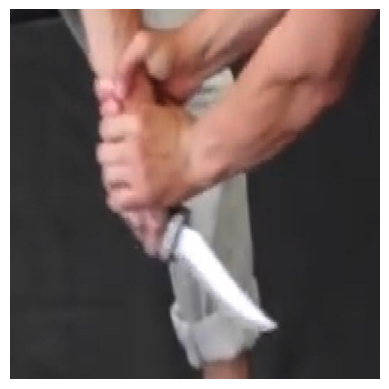

Ground Truth Labels for rgb-0000030_jpg.rf.9e21d58c786f753c371452a99984d947.jpg:
2 0.36875 0.4046875 0.271875 0.2734375
3 0.4609375 0.44296875 0.5453125 0.87578125
2 0.34609375 0.56953125 0.17109375 0.2046875
4 0.56953125 0.70546875 0.31796875 0.33515625


In [26]:
import random
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the validation images
valid_images_path = '/content/drive/MyDrive/dataset/valid/images/*.jpg'
valid_labels_path = '/content/drive/MyDrive/dataset/valid/labels/'

# Get a list of all validation images
image_paths = glob.glob(valid_images_path)

# Randomly select an image
selected_image_path = random.choice(image_paths)
selected_image_name = os.path.basename(selected_image_path)
selected_label_path = os.path.join(valid_labels_path, selected_image_name.replace('.jpg', '.txt'))

# Perform inference on the selected image
results = model(selected_image_path)

# Display the image and results
img = mpimg.imread(selected_image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

# Iterate through results to display
for result in results:
    result.show()

# Print ground truth labels
with open(selected_label_path, 'r') as file:
    labels = file.readlines()
    print(f"Ground Truth Labels for {selected_image_name}:")
    for label in labels:
        print(label.strip())
